In [3]:
import datetime as dt
from typing import List
import pyomo.environ as pyo
import re

In [4]:
from Taller3.P2_TSP.util import generar_ciudades_con_distancias, plotear_ruta, get_min_distance, get_max_distance, \
    get_average_distance, get_average_distance_for_city, delta_time_mm_ss, get_path, calculate_path_distance, \
    get_min_distances, get_max_distances
from Taller3.P2_TSP.util_nearest_neighbor import nearest_neighbor



In [5]:
class TSP:
    def __init__(self, ciudades, distancias, heuristics: List[str]):
        self.max_possible_distance = None
        self.min_possible_distance = None
        self.ciudades = ciudades
        self.distancias = distancias
        self.heuristics = heuristics
        self.min_distance = get_min_distance(distancias)
        self.max_distance = get_max_distance(distancias)
        self.average_distance = get_average_distance(distancias)
        self.average_distance_for_city = get_average_distance_for_city(distancias)
        self.min_distance_for_city = get_min_distances(distancias)
        self.max_distance_for_city = get_max_distances(distancias)
        self.cal_min_max_distances()

    def cal_min_max_distances(self):
        medium_low_distance = (self.min_distance + self.average_distance) / 2
        self.min_possible_distance = medium_low_distance * len(self.ciudades) * 0.25
        self.max_possible_distance = medium_low_distance * len(self.ciudades) * 0.6


    def print_min_max_distances(self):
        print(f"Distancia mínima entre nodos: {self.min_distance}")
        print(f"Distancia máxima entre nodos: {self.max_distance}")
        print(f"Distancia promedio entre nodos: {self.average_distance}")
        print(f"Distancia Total mínima posible: {self.min_possible_distance}")
        print(f"Distancia Total máxima posible: {self.max_possible_distance}")
        print(f"Heurísticas aplicadas: {self.heuristics}")

    def encontrar_la_ruta_mas_corta(self, mipgap, time_limit, tee):
        start_time = dt.datetime.now()

        _model = pyo.ConcreteModel()

        cities = list(self.ciudades.keys())
        n_cities = len(cities)


        # Sets to work with (conjuntos)
        _model.M = pyo.Set(initialize=self.ciudades.keys())
        _model.N = pyo.Set(initialize=self.ciudades.keys())

        # Index for the dummy variable u
        _model.U = pyo.Set(initialize=cities[1:])

        # Variables
        _model.x = pyo.Var(_model.N, _model.M, within=pyo.Binary)
        _model.u = pyo.Var(_model.N, bounds=(0, n_cities - 1), within=pyo.NonNegativeIntegers)

        # Objetive Function: (función objetivo a minimizar)
        def obj_rule(model):
            return sum(self.distancias[i, j] * model.x[i, j] for i in model.N for j in model.M if i != j)

        _model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Restricciones
        # Desde cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_desde(model, city_j):
            return sum(model.x[i, city_j]  for i in model.N if city_j != i) == 1

        _model.one_way_i_j = pyo.Constraint(_model.M, rule=regla_una_entrada_una_salida_por_ciudad_desde)

        # Hacia cada ciudad exactamente una arista
        def regla_una_entrada_una_salida_por_ciudad_hacia(model, city_i):
            return sum(model.x[city_i, j] for j in model.M if city_i != j) == 1

        _model.one_way_j_i = pyo.Constraint(_model.N, rule=regla_una_entrada_una_salida_por_ciudad_hacia)

        def rule_formando_path(model, i, j):
            if i != j:
                return model.u[i] - model.u[j] + model.x[i, j] * n_cities <= n_cities - 1
            else:
                # No se puede ir de una ciudad a la misma
                return pyo.Constraint.Skip

        _model.complete_path = pyo.Constraint(_model.U, _model.N, rule=rule_formando_path)

        def rule_asegurar_viaje(model, i, j):
            if i == j:
                return model.x[i, j] == 0
            return pyo.Constraint.Skip
        _model.no_self_travel = pyo.Constraint(_model.N, _model.M, rule=rule_asegurar_viaje)

        # Heurísticas:

        # Añadiendo limites a la función objetivo como una heurística
        if "limitar_funcion_objetivo" in self.heuristics:
            _model.obj_lower_bound = pyo.Constraint(expr=_model.obj >= self.min_possible_distance)
            _model.obj_upper_bound = pyo.Constraint(expr=_model.obj <= self.max_possible_distance)

        if "vecino_cercano" in self.heuristics:
            def rule_vecino_cercano(model, i, j):
                if i == j:
                    return pyo.Constraint.Skip
                print(i, self.min_distance, self.average_distance,  self.min_distance_for_city[i], self.max_distance_for_city[i], self.average_distance_for_city[i])
                if self.average_distance_for_city[i] > self.average_distance:
                     return pyo.Constraint.Skip
                expr = model.x[i,j] * self.distancias[i,j] <= (self.average_distance_for_city[i] + self.min_distance_for_city[i])/2
                return expr
            _model.nearest_neighbor = pyo.Constraint(_model.N, _model.M, rule=rule_vecino_cercano)

        # Initialize empty set for dynamic constraints (optional)
        # _model.subtour_constraint = pyo.ConstraintList()


        # Resolver el modelo
        solver = pyo.SolverFactory('glpk')
        solver.options['mipgap'] = mipgap
        solver.options['tmlim'] = time_limit
        results = solver.solve(_model, tee=tee)

        execution_time = dt.datetime.now() - start_time
        print(f"Tiempo de ejecución: {delta_time_mm_ss(execution_time)}")
        self.print_min_max_distances()

        # Mostrar resultados
        if results.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("Ruta óptima encontrada:")
        else:
            print("No se encontró una solución óptima, la siguiente es la mejor solución encontrada:")

        edges = dict()
        valid_paths = []
        for v in _model.component_data_objects(pyo.Var):
            if v.domain == pyo.Boolean and v.value is not None and v.value > 0:
                edge = re.search(r'\[(\w\d)*,(\w\d)*]', v.name)
                city1, city2 = edge.group(1), edge.group(2)
                key = f"{city1}_{city2}"
                # Esto evita caer en ciclos cerrados
                if key not in valid_paths:
                    valid_paths += [f"{city1}_{city2}", f"{city2}_{city1}"]
                    edges[city1] = city2

        initial_city = cities[0]
        path = get_path(edges, initial_city, [])
        path.append(path[0])
        distance = calculate_path_distance(self.distancias, path)
        print("Distancia total recorrida:", distance)
        return path



    def plotear_resultado(self, ruta: List[str], mostrar_anotaciones: bool = True):
        plotear_ruta(self.ciudades, self.distancias, ruta, mostrar_anotaciones)


In [5]:
def study_nearest_neighbor(n_cities):
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    ruta = nearest_neighbor(ciudades, distancias)
    plotear_ruta(ciudades, distancias, ruta, True)


In [24]:
def study_case_1():
    city_counts = [10, 20, 30, 40, 50]  # Cantidades de ciudades a probar
    mipgap = 0.05
    time_limit = 30
    tee = False
    heuristics = []
    
    for n_cities in city_counts:
        print(f"Estudiando caso con {n_cities} ciudades:")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        tsp = TSP(ciudades, distancias, heuristics)
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        tsp.plotear_resultado(ruta)
        print(f"Resultado para {n_cities} ciudades completado.\n")


In [13]:
def study_case_2():
    n_cities = 70
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['limitar_funcion_objetivo']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.2
    time_limit = 40
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


In [14]:
def study_case_3():
    n_cities = 100
    ciudades, distancias = generar_ciudades_con_distancias(n_cities)
    # con heuristicas
    heuristics = ['vecino_cercano']
    # sin heuristicas
    # heuristics = []
    tsp = TSP(ciudades, distancias, heuristics)
    mipgap = 0.05
    time_limit = 60
    tee = True
    ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
    tsp.plotear_resultado(ruta, False)


### Ejecucion Literal A P2

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.
Estudiando caso con 10 ciudades:
Tiempo de ejecución: 00:00
Distancia mínima entre nodos: 13.857849761056004
Distancia máxima entre nodos: 196.87965867503937
Distancia promedio entre nodos: 109.71153649851156
Distancia Total mínima posible: 154.46173282445946
Distancia Total máxima posible: 370.7081587787027
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 570.6995632723516


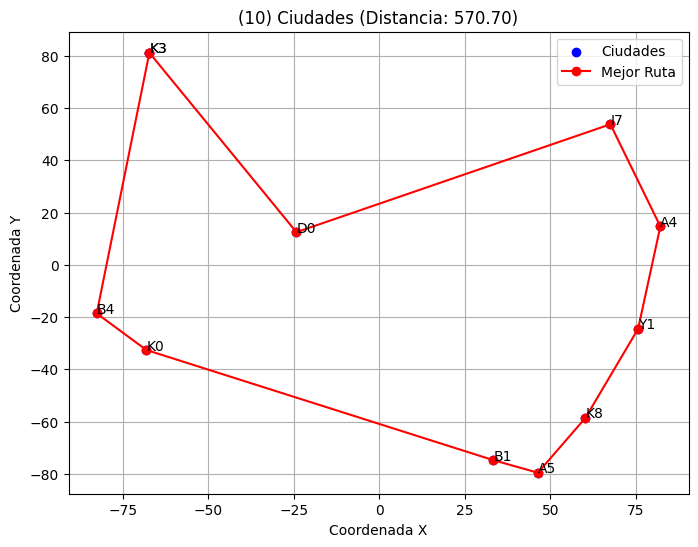

Resultado para 10 ciudades completado.

Estudiando caso con 20 ciudades:
Tiempo de ejecución: 00:05
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 199.3987211593896
Distancia promedio entre nodos: 104.14313439828004
Distancia Total mínima posible: 265.6078359957001
Distancia Total máxima posible: 637.4588063896803
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 718.4738041093337


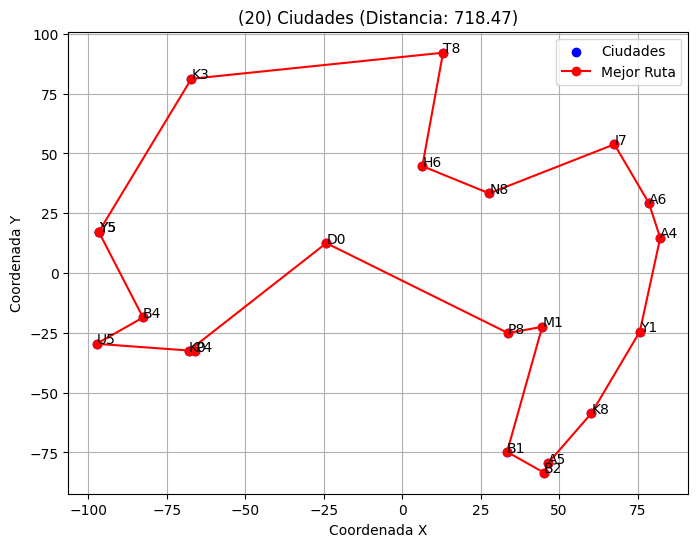

Resultado para 20 ciudades completado.

Estudiando caso con 30 ciudades:
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 199.3987211593896
Distancia promedio entre nodos: 103.75681401513364
Distancia Total mínima posible: 396.9630525567511
Distancia Total máxima posible: 952.7113261362026
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 931.740029920441


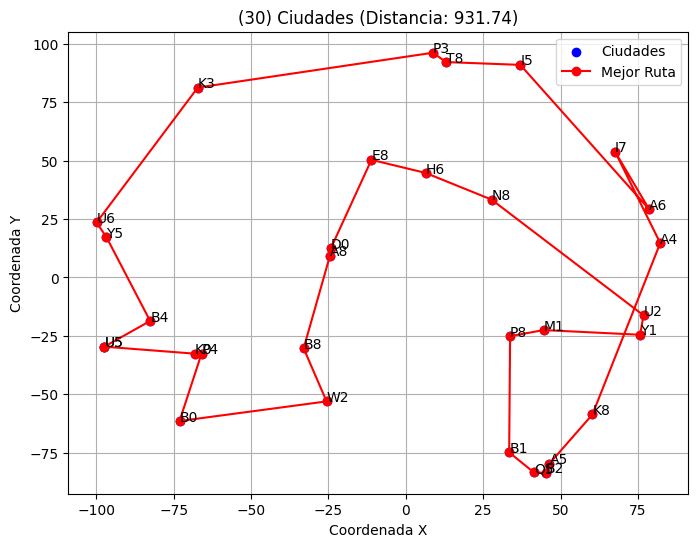

Resultado para 30 ciudades completado.

Estudiando caso con 40 ciudades:
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 202.6153992173349
Distancia promedio entre nodos: 101.09527133150198
Distancia Total mínima posible: 515.9763566575099
Distancia Total máxima posible: 1238.3432559780238
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1131.7867881280401


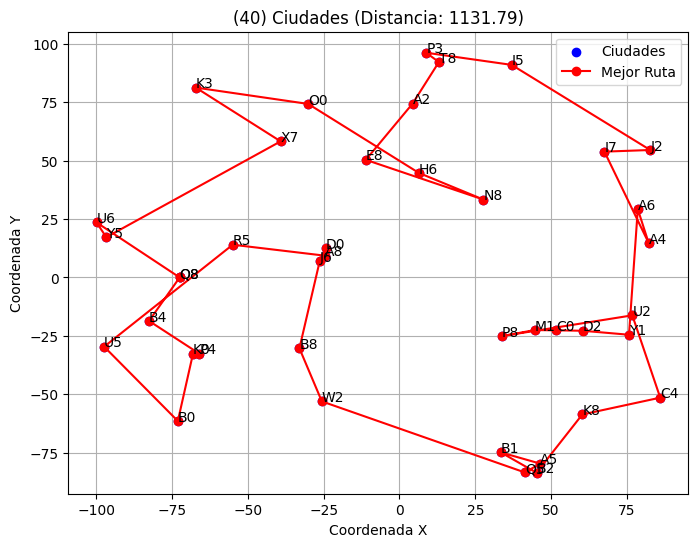

Resultado para 40 ciudades completado.

Estudiando caso con 50 ciudades:
Tiempo de ejecución: 00:30
Distancia mínima entre nodos: 2.0999999999999943
Distancia máxima entre nodos: 202.6153992173349
Distancia promedio entre nodos: 97.67061537707829
Distancia Total mínima posible: 623.5663461067393
Distancia Total máxima posible: 1496.5592306561741
Heurísticas aplicadas: []
No se encontró una solución óptima, la siguiente es la mejor solución encontrada:
Distancia total recorrida: 1125.9456376118662


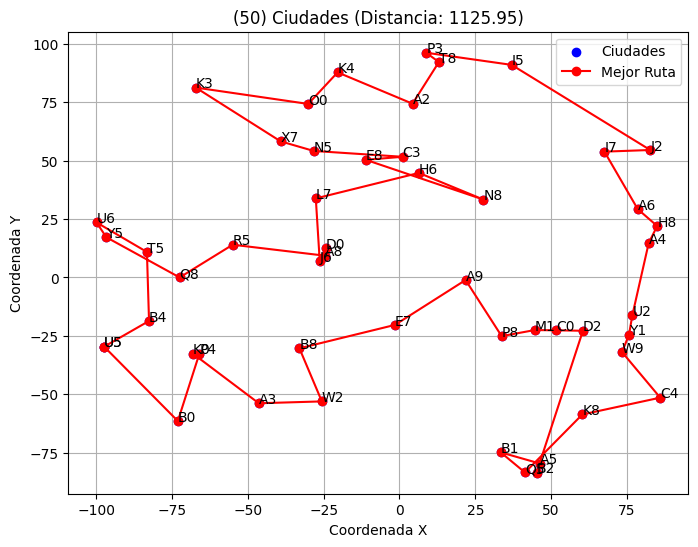

Resultado para 50 ciudades completado.



In [25]:
if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    #study_nearest_neighbor(100)
    # Solve the TSP problem
    study_case_1()
    # study_case_2()
    #study_case_3()

In [22]:
# Aplicando la heurisitica del archivo util_nearest_neighbor
def study_case_1_heu():
    city_counts = [10, 20, 30, 40, 50]  # Cantidades de ciudades a probar
    mipgap = 0.05
    time_limit = 30
    tee = False
    heuristics = []
    
    for n_cities in city_counts:
        print(f"Estudiando caso con {n_cities} ciudades:")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        
        # Uso de la heurística del vecino cercano
        ruta = nearest_neighbor(ciudades, distancias)
        
        # Simulamos un objeto TSP para generar la visualización
        tsp = TSP(ciudades, distancias, heuristics)
        tsp.plotear_resultado(ruta)
        
        print(f"Resultado para {n_cities} ciudades completado.\n")

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.
Estudiando caso con 10 ciudades:


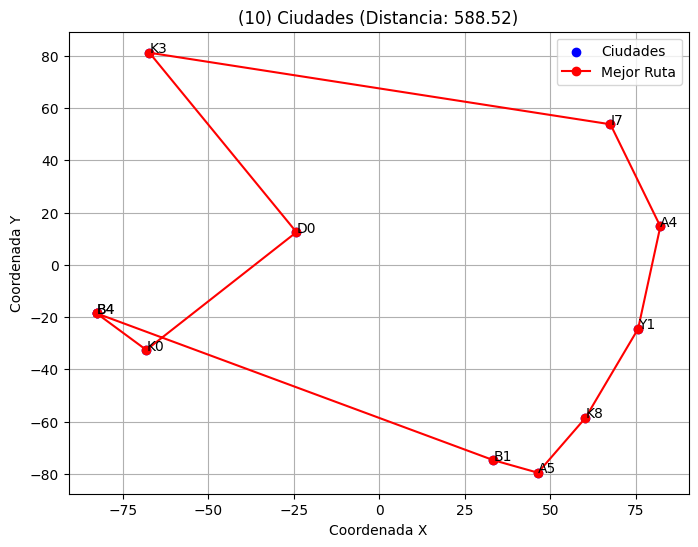

Resultado para 10 ciudades completado.

Estudiando caso con 20 ciudades:


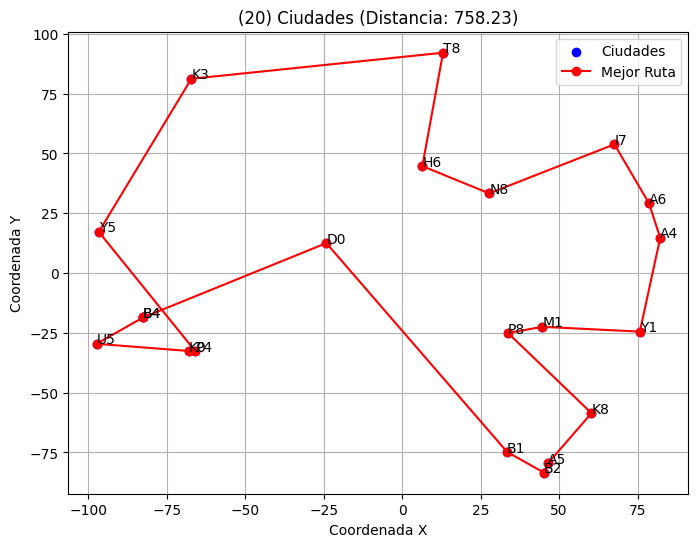

Resultado para 20 ciudades completado.

Estudiando caso con 30 ciudades:


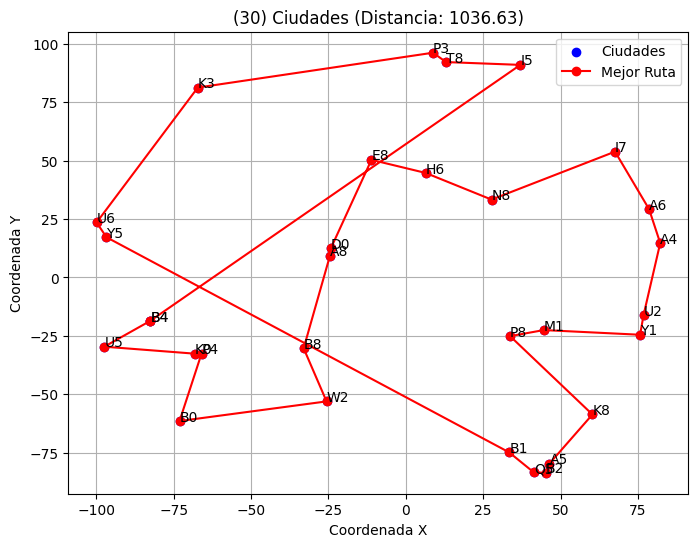

Resultado para 30 ciudades completado.

Estudiando caso con 40 ciudades:


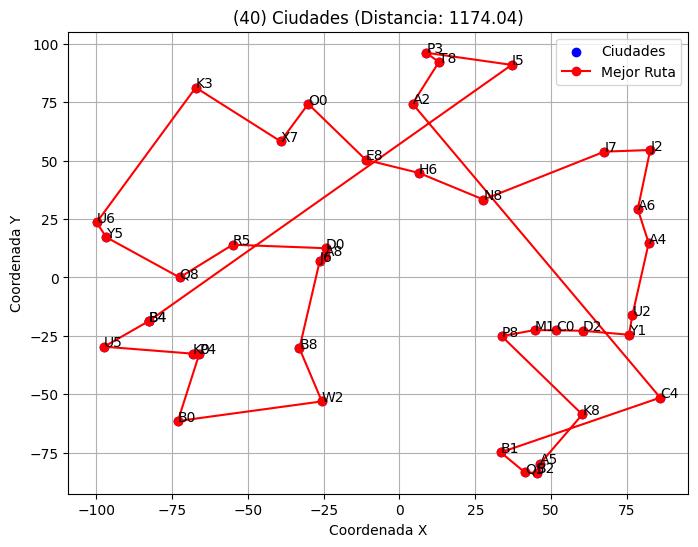

Resultado para 40 ciudades completado.

Estudiando caso con 50 ciudades:


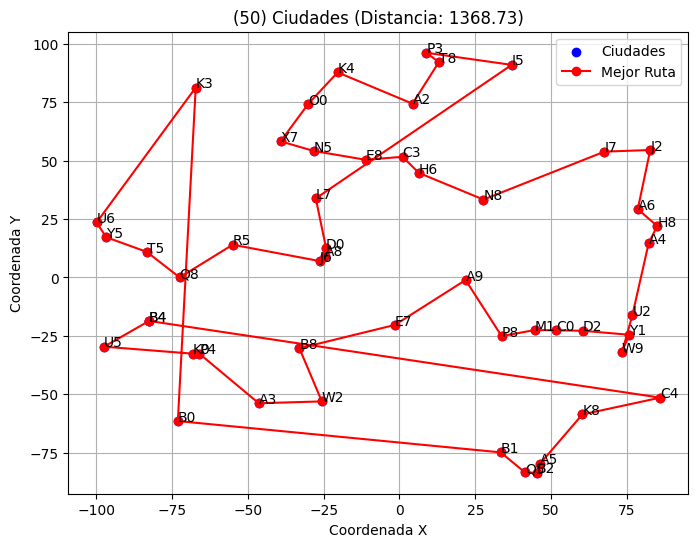

Resultado para 50 ciudades completado.



In [23]:
if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    #study_nearest_neighbor(100)
    # Solve the TSP problem
    study_case_1_heu()

### Ejecucion Literal B P2

tee es un booleano que determina si se debe mostrar en la consola la salida generada por el solver durante la resolución del modelo.

tee=True: Muestra en la consola los mensajes y el progreso del solver. Es útil para monitorear cómo avanza la resolución, detectar posibles problemas y entender mejor el comportamiento del solver.

tee=False: Oculta la salida del solver. Esto puede ser útil cuando se ejecuta el modelo en un entorno donde se prefiere una salida más limpia o cuando se realiza una ejecución masiva y no se requiere monitoreo detallado.

In [8]:
def study_case_1_par_tee():
    city_counts = [10, 20, 30, 40, 50]  # Cantidades de ciudades a probar
    mipgap = 0.05
    time_limit = 300
    tee = True
    heuristics = []
    
    for n_cities in city_counts:
        print(f"Estudiando caso con {n_cities} ciudades:")
        ciudades, distancias = generar_ciudades_con_distancias(n_cities)
        tsp = TSP(ciudades, distancias, heuristics)
        ruta = tsp.encontrar_la_ruta_mas_corta(mipgap, time_limit, tee)
        tsp.plotear_resultado(ruta)
        print(f"Resultado para {n_cities} ciudades completado.\n")

Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.
Estudiando caso con 10 ciudades:
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --tmlim 300 --write C:\Users\59399\AppData\Local\Temp\tmpyqr6m3_v.glpk.raw
 --wglp C:\Users\59399\AppData\Local\Temp\tmpaokokxxg.glpk.glp --cpxlp C:\Users\59399\AppData\Local\Temp\tmp6eqiftu3.pyomo.lp
Reading problem data from 'C:\Users\59399\AppData\Local\Temp\tmp6eqiftu3.pyomo.lp'...
C:\Users\59399\AppData\Local\Temp\tmp6eqiftu3.pyomo.lp:987: warning: lower bound of variable 'x204' redefined
C:\Users\59399\AppData\Local\Temp\tmp6eqiftu3.pyomo.lp:987: warning: upper bound of variable 'x204' redefined
111 rows, 110 columns, 433 non-zeros
110 integer variables, 100 of which are binary
1087 lines were read
Writing problem data to 'C:\Users\59399\AppData\Local\Temp\tmpaokokxxg.glpk.glp'...
858 lines were written
GLPK Integer Optimizer, v4.65
111 rows, 110 columns, 433 non-zeros
110 inte

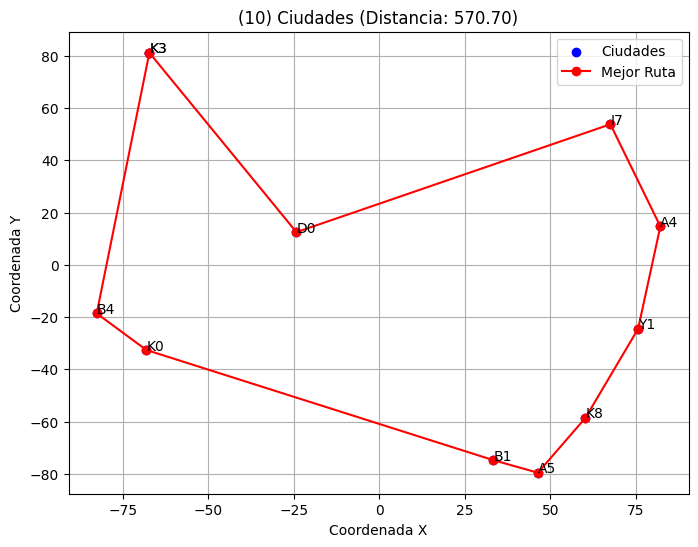

Resultado para 10 ciudades completado.

Estudiando caso con 20 ciudades:
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --tmlim 300 --write C:\Users\59399\AppData\Local\Temp\tmpjlxgpxzv.glpk.raw
 --wglp C:\Users\59399\AppData\Local\Temp\tmpscwf9fja.glpk.glp --cpxlp C:\Users\59399\AppData\Local\Temp\tmpo1oanwm4.pyomo.lp
Reading problem data from 'C:\Users\59399\AppData\Local\Temp\tmpo1oanwm4.pyomo.lp'...
C:\Users\59399\AppData\Local\Temp\tmpo1oanwm4.pyomo.lp:3957: warning: lower bound of variable 'x804' redefined
C:\Users\59399\AppData\Local\Temp\tmpo1oanwm4.pyomo.lp:3957: warning: upper bound of variable 'x804' redefined
421 rows, 420 columns, 1863 non-zeros
420 integer variables, 400 of which are binary
4357 lines were read
Writing problem data to 'C:\Users\59399\AppData\Local\Temp\tmpscwf9fja.glpk.glp'...
3508 lines were written
GLPK Integer Optimizer, v4.65
421 rows, 420 columns, 1863 non-zeros
420 integer variables, 400 of which are bin

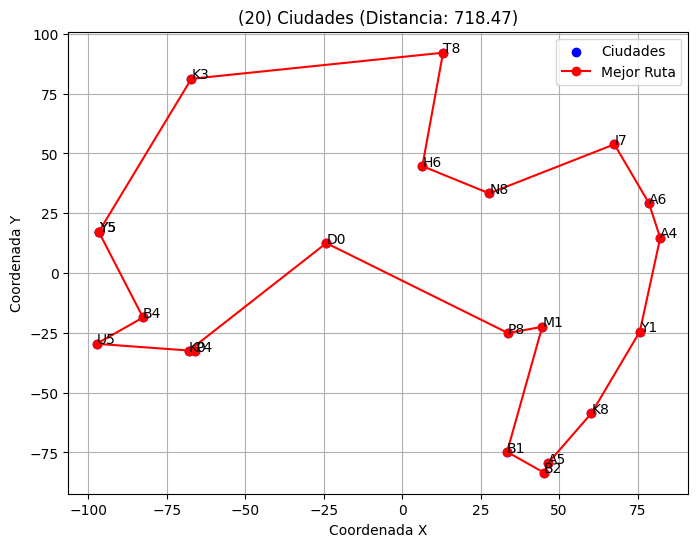

Resultado para 20 ciudades completado.

Estudiando caso con 30 ciudades:
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --tmlim 300 --write C:\Users\59399\AppData\Local\Temp\tmphyraood0.glpk.raw
 --wglp C:\Users\59399\AppData\Local\Temp\tmphmo67amo.glpk.glp --cpxlp C:\Users\59399\AppData\Local\Temp\tmppm8hp_3q.pyomo.lp
Reading problem data from 'C:\Users\59399\AppData\Local\Temp\tmppm8hp_3q.pyomo.lp'...
C:\Users\59399\AppData\Local\Temp\tmppm8hp_3q.pyomo.lp:8927: warning: lower bound of variable 'x1804' redefined
C:\Users\59399\AppData\Local\Temp\tmppm8hp_3q.pyomo.lp:8927: warning: upper bound of variable 'x1804' redefined
931 rows, 930 columns, 4293 non-zeros
930 integer variables, 900 of which are binary
9827 lines were read
Writing problem data to 'C:\Users\59399\AppData\Local\Temp\tmphmo67amo.glpk.glp'...
7958 lines were written
GLPK Integer Optimizer, v4.65
931 rows, 930 columns, 4293 non-zeros
930 integer variables, 900 of which are b

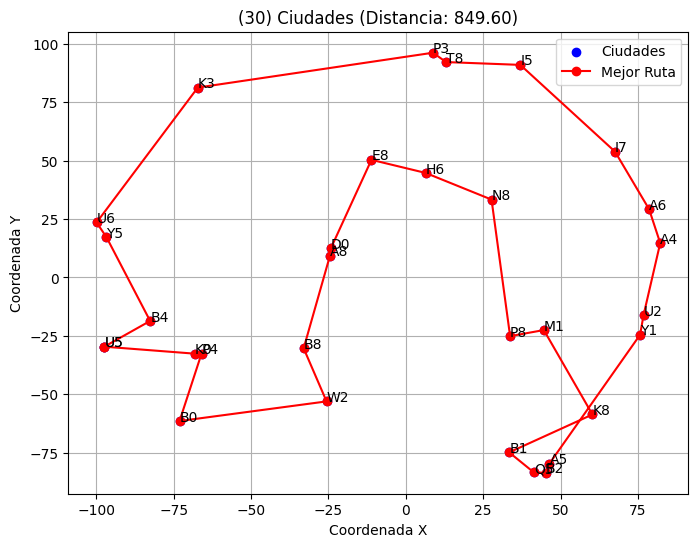

Resultado para 30 ciudades completado.

Estudiando caso con 40 ciudades:
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --tmlim 300 --write C:\Users\59399\AppData\Local\Temp\tmplvhuey05.glpk.raw
 --wglp C:\Users\59399\AppData\Local\Temp\tmp7pyj7l3z.glpk.glp --cpxlp C:\Users\59399\AppData\Local\Temp\tmpba1alyny.pyomo.lp
Reading problem data from 'C:\Users\59399\AppData\Local\Temp\tmpba1alyny.pyomo.lp'...
C:\Users\59399\AppData\Local\Temp\tmpba1alyny.pyomo.lp:15897: warning: lower bound of variable 'x3204' redefined
C:\Users\59399\AppData\Local\Temp\tmpba1alyny.pyomo.lp:15897: warning: upper bound of variable 'x3204' redefined
1641 rows, 1640 columns, 7723 non-zeros
1640 integer variables, 1600 of which are binary
17497 lines were read
Writing problem data to 'C:\Users\59399\AppData\Local\Temp\tmp7pyj7l3z.glpk.glp'...
14208 lines were written
GLPK Integer Optimizer, v4.65
1641 rows, 1640 columns, 7723 non-zeros
1640 integer variables, 1600 of

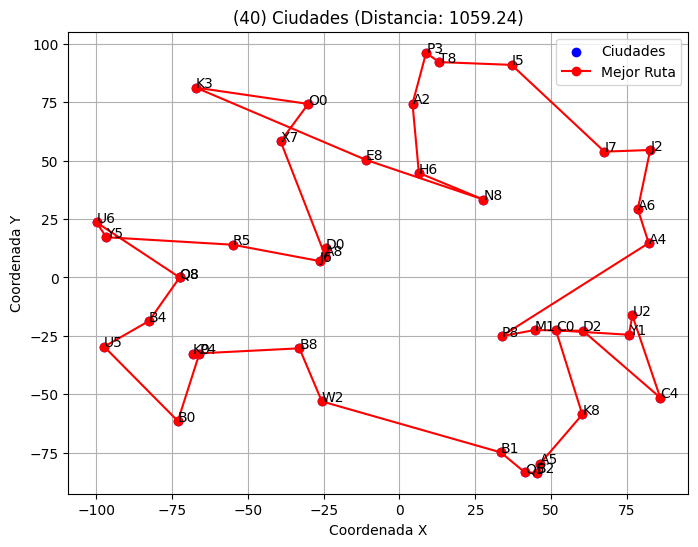

Resultado para 40 ciudades completado.

Estudiando caso con 50 ciudades:
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --mipgap 0.05 --tmlim 300 --write C:\Users\59399\AppData\Local\Temp\tmp5oj7urqf.glpk.raw
 --wglp C:\Users\59399\AppData\Local\Temp\tmptfp8r1hs.glpk.glp --cpxlp C:\Users\59399\AppData\Local\Temp\tmpb83_dawr.pyomo.lp
Reading problem data from 'C:\Users\59399\AppData\Local\Temp\tmpb83_dawr.pyomo.lp'...
C:\Users\59399\AppData\Local\Temp\tmpb83_dawr.pyomo.lp:24867: warning: lower bound of variable 'x5004' redefined
C:\Users\59399\AppData\Local\Temp\tmpb83_dawr.pyomo.lp:24867: warning: upper bound of variable 'x5004' redefined
2551 rows, 2550 columns, 12153 non-zeros
2550 integer variables, 2500 of which are binary
27367 lines were read
Writing problem data to 'C:\Users\59399\AppData\Local\Temp\tmptfp8r1hs.glpk.glp'...
22258 lines were written
GLPK Integer Optimizer, v4.65
2551 rows, 2550 columns, 12153 non-zeros
2550 integer variables, 2500 

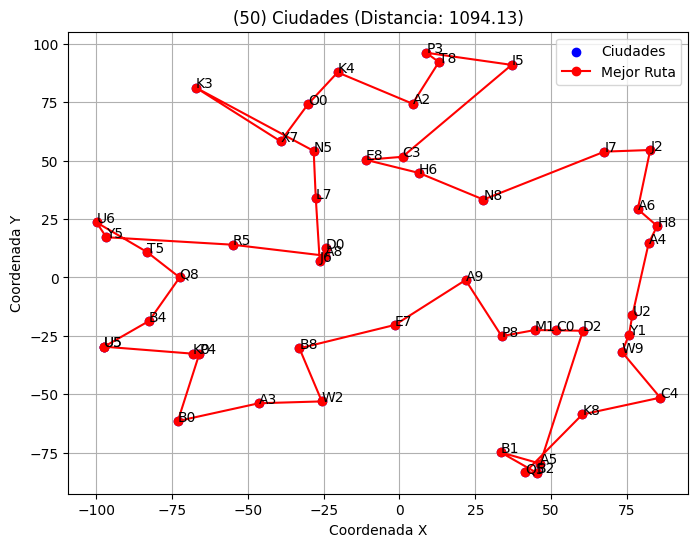

Resultado para 50 ciudades completado.



In [9]:
if __name__ == "__main__":
    print("Se ha colocado un límite de tiempo de 30 segundos para la ejecución del modelo.")
    # as reference, see nearest neighbor heuristic
    #study_nearest_neighbor(100)
    # Solve the TSP problem
    study_case_1_par_tee()

El parámetro tee es una herramienta para monitorear y depurar la resolución de modelos de optimización en Pyomo. Al activarlo, se obtiene una visión detallada del proceso que sigue el solver para encontrar una solución. 
Es importante usarlo con criterio para evitar saturar la consola con información excesiva, especialmente en modelos complejos o durante ejecuciones automatizadas.